## <center>weight initialization 비교하기</center>

> weight initialization은 많은 연구가 이뤄졌던 부분이고, 2000년대 중반부터 최근까지도 굉장히 많은 논문이 나온 분야임     
>    
> 최근 batch normlization이 직접적으로 activation function에 관여하기때문에 중요성이 떨어진 것 같지만 케라스에서는 기본으로 내장되어있을 정도로 중요하기 때문에 실습을 진행   
>   
> 가장 간단하고 상용화된 xavier와 He를 비교해보려함.

### ***xavier***는 sigmoid, tanh처럼 smooth한 함수를 위해 연구된 기법이고, ***He***는  relu함수를 위해 연구된 기법이다.

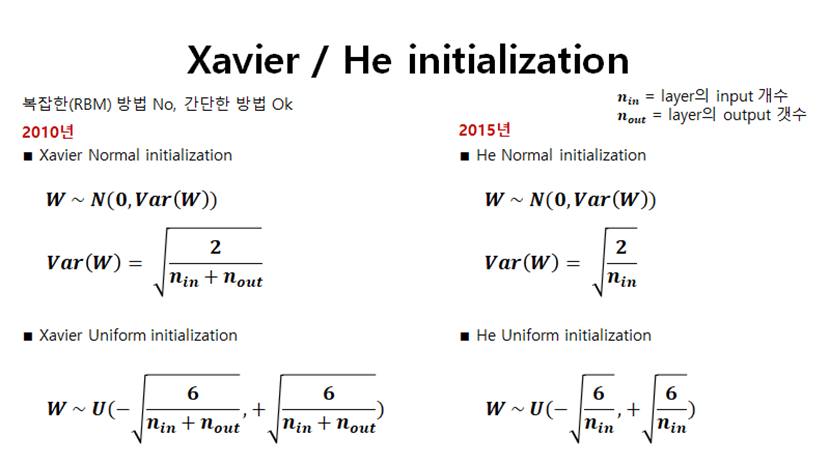

> 식을 비교하면 He가 relu함수를 중심으로 연구됐기때문에 next 뉴런의 개수가 반영되지 않아 분산이 2배쯤은 더 크다.

In [1]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [5]:
# dataset loader
# 데이터는 mnist를 이용함.
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [6]:
# nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()

In [7]:
# xavier initialization
torch.nn.init.kaiming_normal_(linear1.weight)
torch.nn.init.kaiming_normal_(linear2.weight)
torch.nn.init.kaiming_normal_(linear3.weight)
torch.nn.init.kaiming_normal_(linear4.weight)
torch.nn.init.kaiming_normal_(linear5.weight)

Parameter containing:
tensor([[-0.0181, -0.0601,  0.0065,  ..., -0.0023, -0.0869,  0.0193],
        [-0.0550,  0.0295, -0.0036,  ..., -0.0282,  0.1071, -0.0541],
        [-0.0315, -0.0076,  0.0385,  ..., -0.0657,  0.0230, -0.1208],
        ...,
        [ 0.0177,  0.0831, -0.0076,  ..., -0.0875,  0.0497,  0.0202],
        [-0.0309, -0.0147, -0.0419,  ...,  0.0261,  0.1329, -0.0386],
        [ 0.0294,  0.0650, -0.1202,  ...,  0.0640, -0.1027,  0.0356]],
       requires_grad=True)

In [8]:
# model
model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device)

In [9]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.251604915
Epoch: 0002 cost = 0.083701730
Epoch: 0003 cost = 0.053125110
Epoch: 0004 cost = 0.037400857
Epoch: 0005 cost = 0.028350411
Epoch: 0006 cost = 0.023296917
Epoch: 0007 cost = 0.021509413
Epoch: 0008 cost = 0.017928546
Epoch: 0009 cost = 0.016122736
Epoch: 0010 cost = 0.015367291
Epoch: 0011 cost = 0.012639412
Epoch: 0012 cost = 0.013095262
Epoch: 0013 cost = 0.009777523
Epoch: 0014 cost = 0.008537781
Epoch: 0015 cost = 0.008586100
Learning finished


In [11]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

C:\Users\5788j\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\5788j\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9768000245094299
Label:  8
Prediction:  8


### accuracy를 비교한 결과
#### xavier : 0.9804999828338623
####    He    : 0.9768000245094299
    
mnist의 데이터가 너무 단순해서인지 layer를 3개 정도만 쌓아서인지는 모르겠지만, 오히려 xavier의 결과가 더 좋게 나왔다.    
분산을 크게하면 더 좋지 않다는 결과인데 뉴런의 개수, layer 개수, 데이터의 특성 등을 고려해서 경험을 쌓아야할 것 같음